In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/projects/Opt4ML/batch-norm-helps-optimization

/content/drive/MyDrive/projects/Opt4ML/batch-norm-helps-optimization


# Base VGG training and testing

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

<ipython-input-3-1f0008edec47>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


## Constants (parameters) initialization

In [4]:
device_id = 0
num_workers = 4

batch_size = 128
default_learning_rate = 0.1

## CIFAR-10 data load and preproc

In [5]:
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import PIL.Image as Image
from torch import nn
import numpy as np
import torch.optim as optim
import pandas as pd
import torch
from torchvision import transforms, utils
import torchvision.models as models
import torchvision.datasets as datasets
import os
import sys
import random
from tqdm import tqdm as tqdm
from IPython import display

In [6]:
# add our package dir to path
module_path = os.getcwd()
sys.path.append(module_path)

home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

Make sure you are using the right device.

In [7]:
device_id = device_id
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(device_id)

device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device_id))

cuda:0
Tesla T4


In [8]:
class PartialDataset(Dataset):
    def __init__(self, dataset, n_items=10):
        self.dataset = dataset
        self.n_items = n_items

    def __getitem__(self):
        return self.dataset.__getitem__()

    def __len__(self):
        return min(self.n_items, len(self.dataset))

In [9]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
train_transform = transforms.Compose(
    [#transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    normalize
    ])
val_transform = transforms.Compose(
    [transforms.ToTensor(),
    normalize
    ])

dataset_train = datasets.CIFAR10(root='../data/', train=True, download=True, transform=train_transform)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataset_val = datasets.CIFAR10(root='../data/', train=False, download=True, transform=val_transform)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=num_workers)


n_items = 10
dataset_train_part = PartialDataset(dataset_train, n_items)
train_loader_part = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Make sure that dataloader works as expected by observing one sample from it.

tensor([[[-0.0431, -0.0431, -0.0353,  ..., -0.0667, -0.0667, -0.0588],
         [-0.0745, -0.0745, -0.0667,  ..., -0.0902, -0.0902, -0.0902],
         [-0.0902, -0.0902, -0.0745,  ..., -0.0824, -0.0980, -0.0980],
         ...,
         [-0.2000, -0.2078, -0.2078,  ..., -0.1843, -0.1843, -0.1765],
         [-0.2078, -0.2078, -0.2078,  ..., -0.1922, -0.1922, -0.1765],
         [-0.1922, -0.1922, -0.1922,  ..., -0.1686, -0.1686, -0.1608]],

        [[ 0.0980,  0.1059,  0.1059,  ...,  0.0745,  0.0745,  0.0824],
         [ 0.0667,  0.0667,  0.0745,  ...,  0.0510,  0.0510,  0.0510],
         [ 0.0588,  0.0510,  0.0667,  ...,  0.0588,  0.0431,  0.0431],
         ...,
         [-0.0431, -0.0510, -0.0510,  ..., -0.0431, -0.0431, -0.0353],
         [-0.0431, -0.0510, -0.0510,  ..., -0.0510, -0.0510, -0.0353],
         [-0.0275, -0.0353, -0.0353,  ..., -0.0353, -0.0275, -0.0118]],

        [[ 0.2941,  0.2941,  0.2941,  ...,  0.2706,  0.2627,  0.2784],
         [ 0.2549,  0.2549,  0.2549,  ...,  0

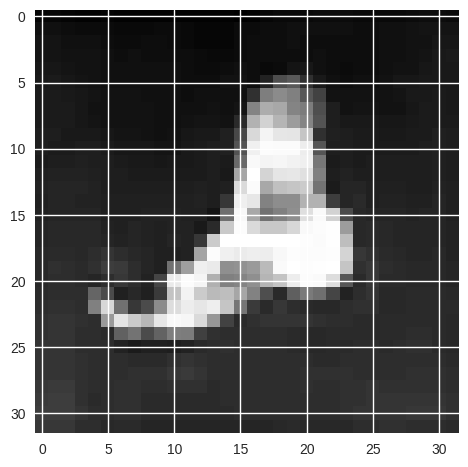

In [10]:
for X,y in train_loader:
    print(X[0])
    print(y[0])
    print(X[0].shape)
    plt.imshow(np.array(X[0,0,:,:]))
    print(X[0].max())
    print(X[0].min())
    break

## Models implementation

In [11]:
def get_number_of_parameters(model):
    parameters_n = 0
    for parameter in model.parameters():
        parameters_n += np.prod(parameter.shape).item()

    return parameters_n

In [12]:

class VGG_A(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()

        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage6 = nn.Sequential(
            nn.Linear(512*1*1, 512),
            #nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            #nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, num_classes))


    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x.view(-1, 512*1*1))
        return x

class VGG_A_Batch(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()

        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage6 = nn.Sequential(
            nn.Linear(512*1*1, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, num_classes))


    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x.view(-1, 512*1*1))
        return x

class VGG_A_Light(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()

        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        '''
        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        '''
        self.classifier = nn.Sequential(
            nn.Linear(32*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))


    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        #x = self.stage3(x)
        #x = self.stage4(x)
        #x = self.stage5(x)
        x = self.classifier(x.view(-1, 32*8*8))
        return x


class VGG_A_Dropout(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()

        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512*1*1, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes))


    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.classifier(x.view(-1, 512*1*1))
        return x

print(get_number_of_parameters(VGG_A()))

9750922


## Final preparations for training

In [13]:
def get_accuracy(model, dataloader, device='cpu'):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)  ## <---
            y = y.to(device)  ## <---
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)

In [14]:
def set_random_seeds(seed_value=0, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu':
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [15]:
def train(model,
          optimizer,
          criterion,
          train_loader,
          val_loader,
          scheduler=None,
          epochs_n=100,
          best_model_path=None):

    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = len(train_loader)
    grads = []
    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:
            scheduler.step()
        model.train()
        grad = []
        learning_curve[epoch] = 0
        for data in train_loader:

            #print(data)

            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            #print(loss.item())
            #loss_list.append(loss.item())
            learning_curve[epoch] += loss.item()
            loss.backward()
            grad.append(model.stage6[4].weight.grad.clone())
            optimizer.step()
        grads.append(grad)
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)

        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if best_model_path:
                torch.save(model.state_dict(), best_model_path)

        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()
    return grads

In [16]:
def train_batch(model,
          optimizer,
          criterion,
          train_loader,
          val_loader,
          scheduler=None,
          epochs_n=100,
          best_model_path=None):

    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = len(train_loader)
    grads = []
    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:
            scheduler.step()
        model.train()
        grad = []
        learning_curve[epoch] = 0
        for data in train_loader:

            #print(data)

            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            #print(loss.item())
            #loss_list.append(loss.item())
            learning_curve[epoch] += loss.item()
            loss.backward()
            grad.append(model.stage6[6].weight.grad.clone())
            optimizer.step()
        grads.append(grad)
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)

        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if best_model_path:
                torch.save(model.state_dict(), best_model_path)

        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()
    return grads

## Visualzing Loss landscape

In [1]:
!pip install loss-landscape-anim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 18.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
from loss_landscape_anim import loss_landscape_anim

loss_landscape_anim(
    n_epochs=10,
    model=VGG_A(),
    datamodule=train_loader,
    optimizer="adam",
    seed=SEED,
    load_model=False,
    output_to_file=True
)

ModuleNotFoundError: ignored

## Training

In [ ]:
epo = 20

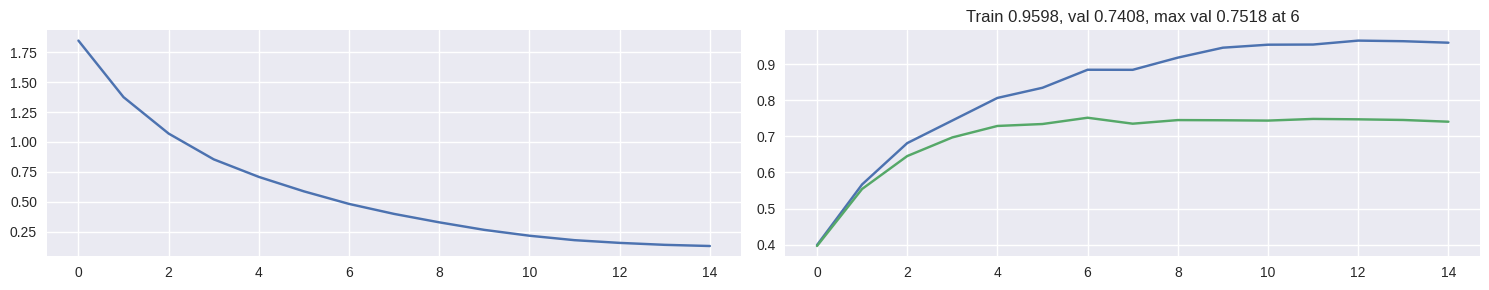


 75%|███████▌  | 15/20 [09:53<03:20, 40.19s/epoch]

In [ ]:
for idx in tqdm(range(20)):
    set_random_seeds(seed_value=1984*idx, device=device)
    model = VGG_A()
    lr = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()

    grads_01 = train(model,
          optimizer,
          criterion,
          train_loader,
          val_loader,
          epochs_n=epo)

    torch.save(model, f"vgg_{idx}.pth")

In [ ]:
os.path.join(os.getcwd(), 'best_vgg_1.pt') #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = VGG_A()
lr = 0.001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

grads_01 = train(model,
      optimizer,
      criterion,
      train_loader,
      val_loader,
      epochs_n=epo)


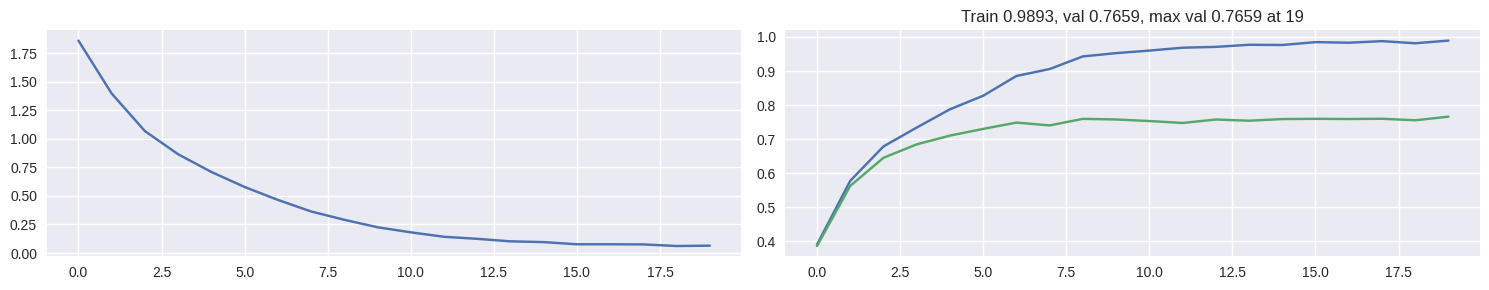

100%|██████████| 20/20 [12:33<00:00, 37.68s/epoch]


In [ ]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A()
lr = 0.0005
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

grads_005 = train(model,
      optimizer,
      criterion,
      train_loader,
      val_loader,
      epochs_n=epo)
torch.save(model, "vgg.pth")

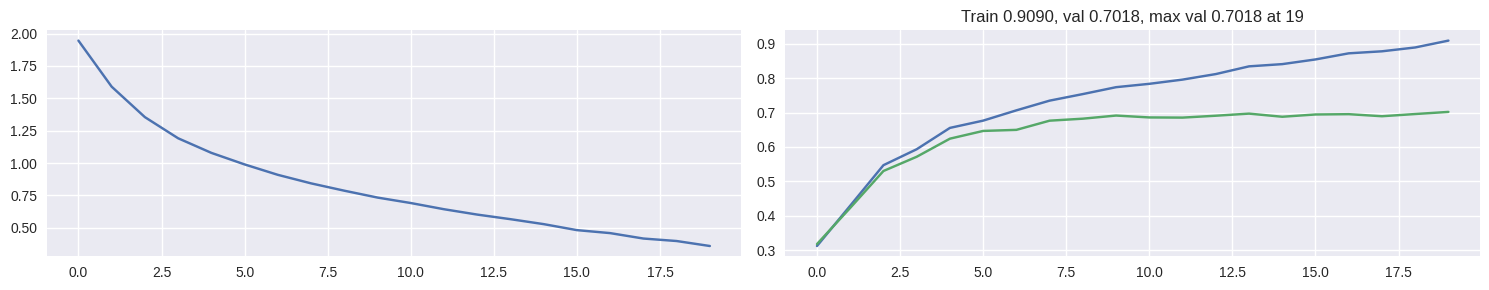

100%|██████████| 20/20 [12:33<00:00, 37.67s/epoch]


In [ ]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A()
lr = 0.002
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

grads_02 = train(model,
      optimizer,
      criterion,
      train_loader,
      val_loader,
      epochs_n=epo)


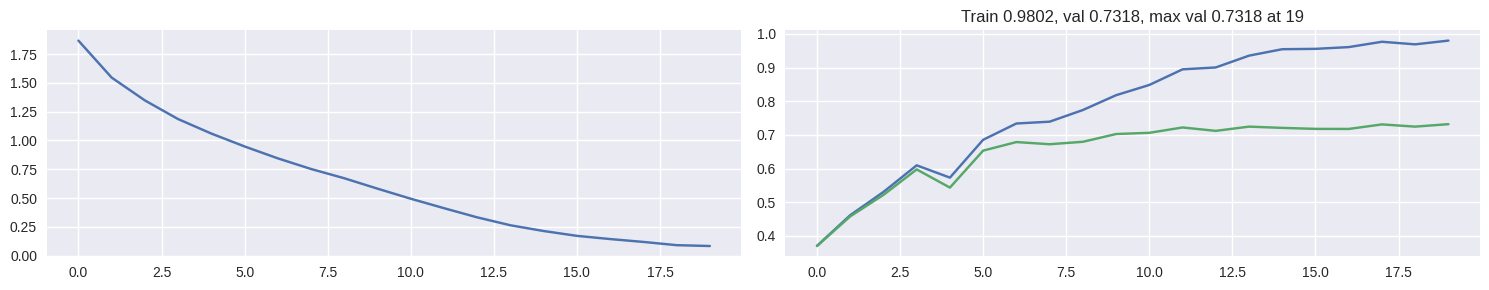

100%|██████████| 20/20 [12:22<00:00, 37.15s/epoch]


In [ ]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A()
lr = 0.0001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)


grads_001 = train(model,
      optimizer,
      criterion,
      train_loader,
      val_loader,
      epochs_n=epo)


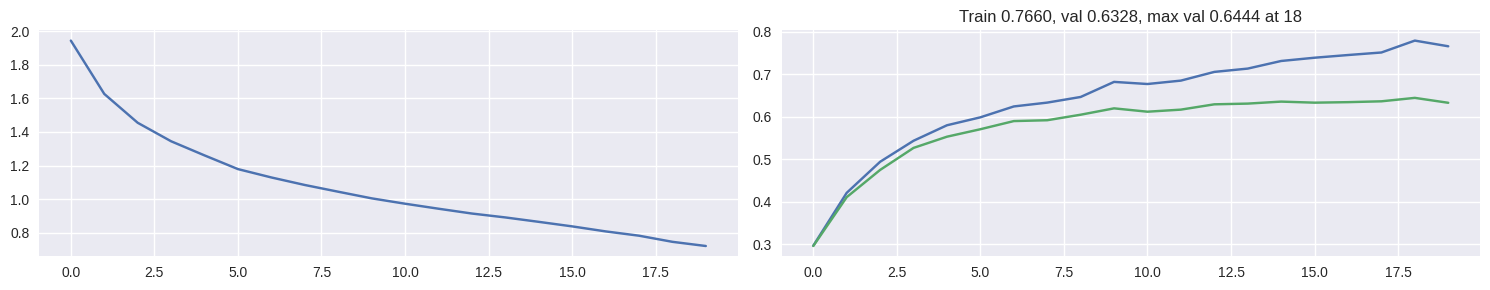

100%|██████████| 20/20 [12:22<00:00, 37.13s/epoch]


In [ ]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A()
lr = 0.003
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

grads_03 = train(model,
      optimizer,
      criterion,
      train_loader,
      val_loader,
      epochs_n=epo)


In [ ]:
#import itertools
lol_01 = np.array(grads_01).flatten()
lol_02 = np.array(grads_02).flatten()
lol_005 = np.array(grads_005).flatten()
lol_001 = np.array(grads_001).flatten()

kek_01 = []
kek_02 = []
kek_005 = []
kek_001 = []
for i in range(1,len(lol_01)):
  kek_01.append((lol_01[i-1] - lol_01[i]).norm(p=2).item())
  kek_02.append((lol_02[i-1] - lol_02[i]).norm(p=2).item())
  kek_005.append((lol_005[i-1] - lol_005[i]).norm(p=2).item())
  kek_001.append((lol_001[i-1] - lol_001[i]).norm(p=2).item())

min_curve = []
max_curve = []
for i in range(len(kek_01)):
    min_curve.append(np.min([kek_01[i], kek_02[i], kek_005[i], kek_001[i]]))
    max_curve.append(np.max([kek_01[i], kek_02[i], kek_005[i], kek_001[i]]))


In [ ]:
plt.figure(figsize=(15, 10))
plt.fill_between(range(len(min_curve)//5+1), min_curve[::5], max_curve[::5])

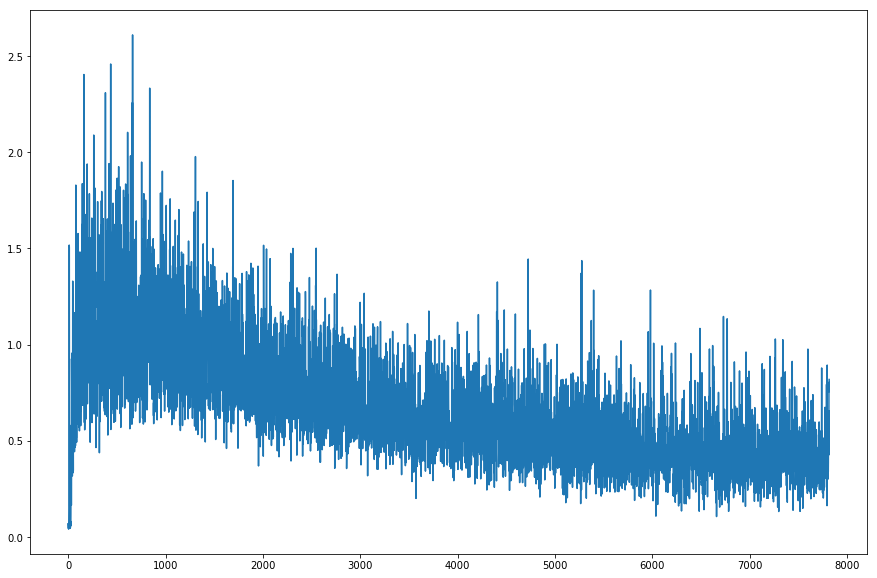

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(len(kek_01)), kek_01)

In [20]:
torch.load(f"vgg.pth")

VGG_A(
  (stage1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

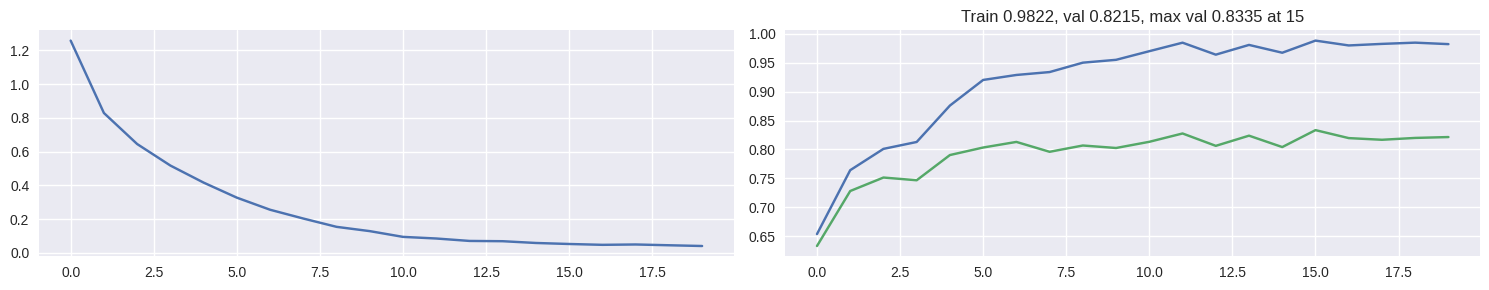


100%|██████████| 8/8 [1:37:12<00:00, 729.03s/it]


In [18]:
for idx in tqdm(range(8)):
    set_random_seeds(seed_value=1984*idx, device=device)
    model = VGG_A_Batch()
    lr = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()

    grads_batch_01 = train_batch(model,
      optimizer,
      criterion,
      train_loader,
      val_loader,
      epochs_n=epo)

    torch.save(model, f"vgg_bn_{idx}.pth")


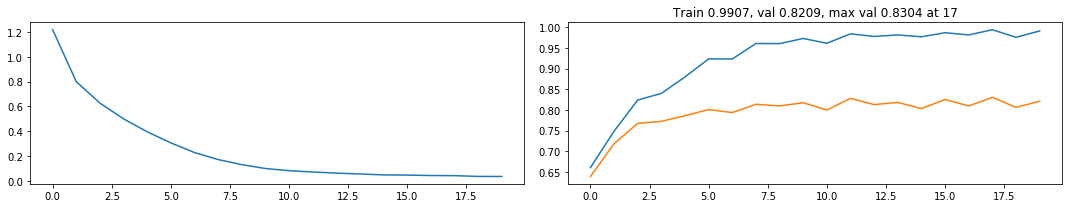

100%|██████████| 20/20 [05:27<00:00, 16.37s/epoch]


In [ ]:
os.path.join(os.getcwd(), 'best_vgg_1.pt') #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Batch()
lr = 0.001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

grads_batch_01 = train_batch(model,
      optimizer,
      criterion,
      train_loader,
      val_loader,
      epochs_n=epo)


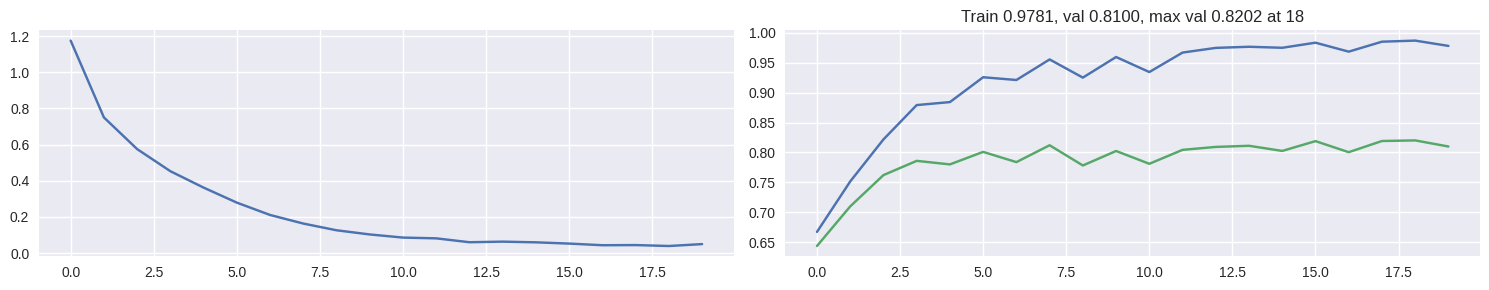

100%|██████████| 20/20 [12:34<00:00, 37.75s/epoch]


In [ ]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Batch()
lr = 0.0005
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

grads_batch_005 = train_batch(model,
      optimizer,
      criterion,
      train_loader,
      val_loader,
      epochs_n=epo)
torch.save(model, "bn_vgg.pth")

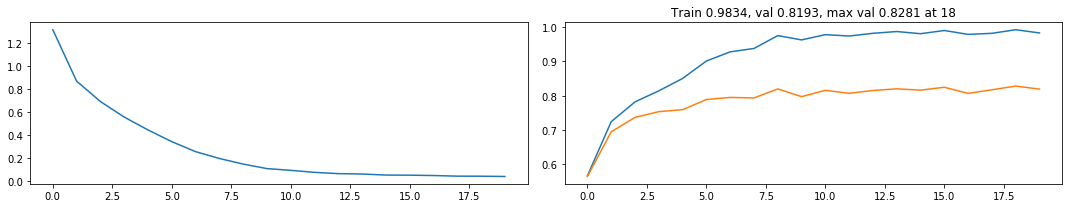

100%|██████████| 20/20 [05:28<00:00, 17.01s/epoch]


In [ ]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Batch()
lr = 0.002
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

grads_batch_02 = train_batch(model,
      optimizer,
      criterion,
      train_loader,
      val_loader,
      epochs_n=epo)


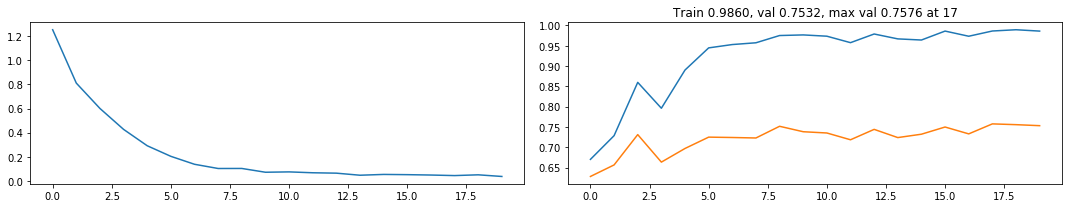

100%|██████████| 20/20 [05:28<00:00, 16.44s/epoch]


In [ ]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Batch()
lr = 0.0001
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)


grads_batch_001 = train_batch(model,
      optimizer,
      criterion,
      train_loader,
      val_loader,
      epochs_n=epo)


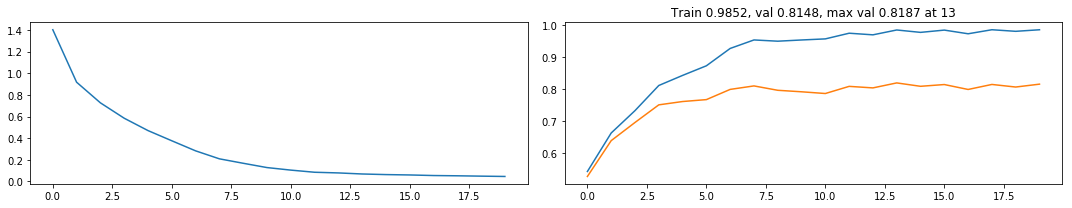

100%|██████████| 20/20 [05:29<00:00, 16.58s/epoch]


In [ ]:
set_random_seeds(seed_value=1984, device=device)
model = VGG_A_Batch()
lr = 0.003
#optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

grads_batch_03 = train_batch(model,
      optimizer,
      criterion,
      train_loader,
      val_loader,
      epochs_n=epo)


In [ ]:
lol_batch_01 = np.array(grads_batch_01).flatten()
lol_batch_02 = np.array(grads_batch_02).flatten()
lol_batch_005 = np.array(grads_batch_005).flatten()
lol_batch_001 = np.array(grads_batch_001).flatten()

kek_batch_01 = []
kek_batch_02 = []
kek_batch_005 = []
kek_batch_001 = []
for i in range(1,len(lol_01)):
  kek_batch_01.append((lol_batch_01[i-1] - lol_batch_01[i]).norm(p=2).item())
  kek_batch_02.append((lol_batch_02[i-1] - lol_batch_02[i]).norm(p=2).item())
  kek_batch_005.append((lol_batch_005[i-1] - lol_batch_005[i]).norm(p=2).item())
  kek_batch_001.append((lol_batch_001[i-1] - lol_batch_001[i]).norm(p=2).item())

min_batch_curve = []
max_batch_curve = []
for i in range(len(kek_01)):
    min_batch_curve.append(np.min([kek_batch_01[i], kek_batch_02[i], kek_batch_005[i], kek_batch_001[i]]))
    max_batch_curve.append(np.max([kek_batch_01[i], kek_batch_02[i], kek_batch_005[i], kek_batch_001[i]]))


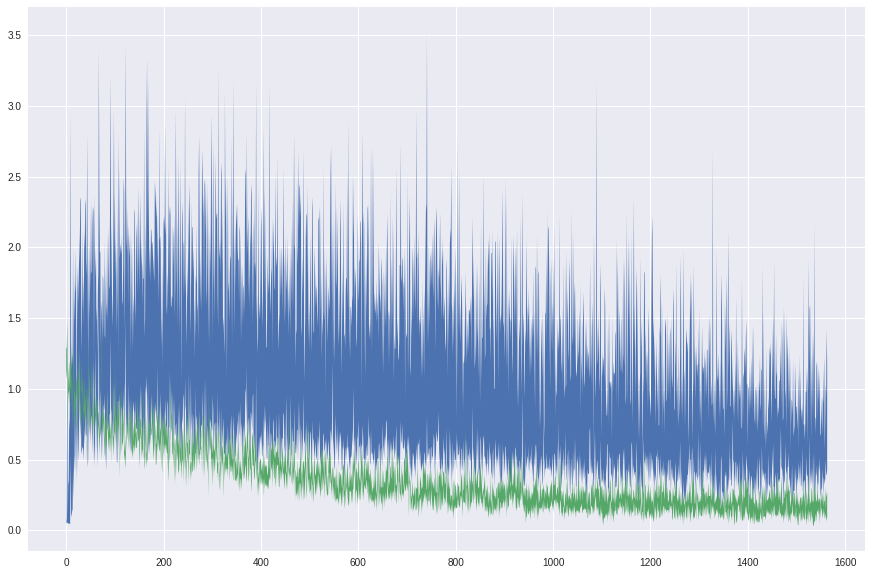

In [ ]:
plt.figure(figsize=(15, 10))
plt.fill_between(range(len(min_curve)//5+1), min_curve[::5], max_curve[::5])
plt.fill_between(range(len(min_batch_curve)//5+1), min_batch_curve[::5], max_batch_curve[::5])
plt.show()

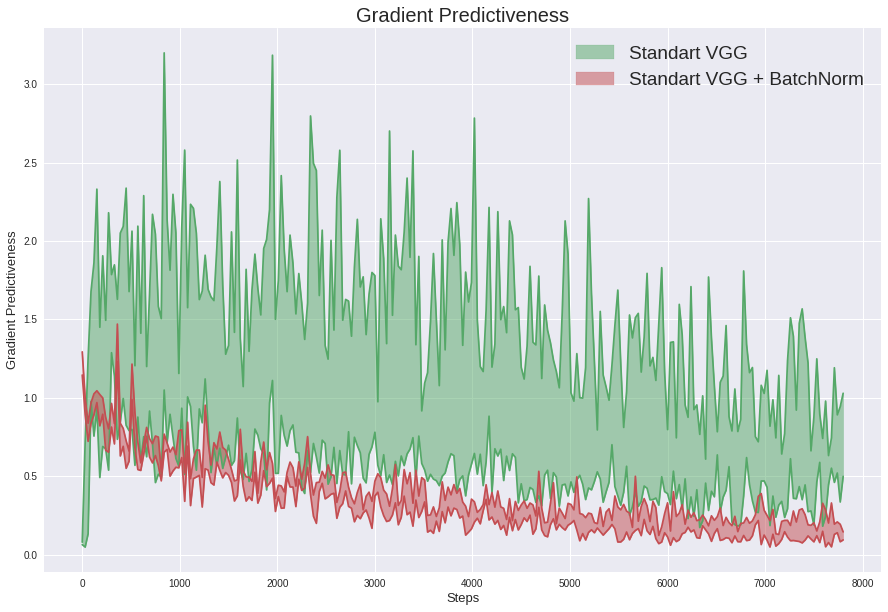

In [ ]:
step = 30
steps = np.arange(0, len(min_curve), step)
plt.figure(figsize=(15, 10))
plt.fill_between(steps, min_curve[::step], max_curve[::step],
                alpha=0.5, color='C1', label='Standart VGG')
plt.plot(steps, min_curve[::step], color='C1')
plt.plot(steps, max_curve[::step], color='C1')

plt.fill_between(steps, min_batch_curve[::step], max_batch_curve[::step],
                alpha=0.5, color='C2', label='Standart VGG + BatchNorm')
plt.plot(steps, min_batch_curve[::step], color='C2')
plt.plot(steps, max_batch_curve[::step], color='C2')

plt.legend(fontsize=19)
plt.title('Gradient Predictiveness', fontsize=20)
plt.ylabel('Gradient Predictiveness', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig(os.path.join(figures_path, 'gradient_predictiveness.png'), dpi=500, quality=100)
plt.show()

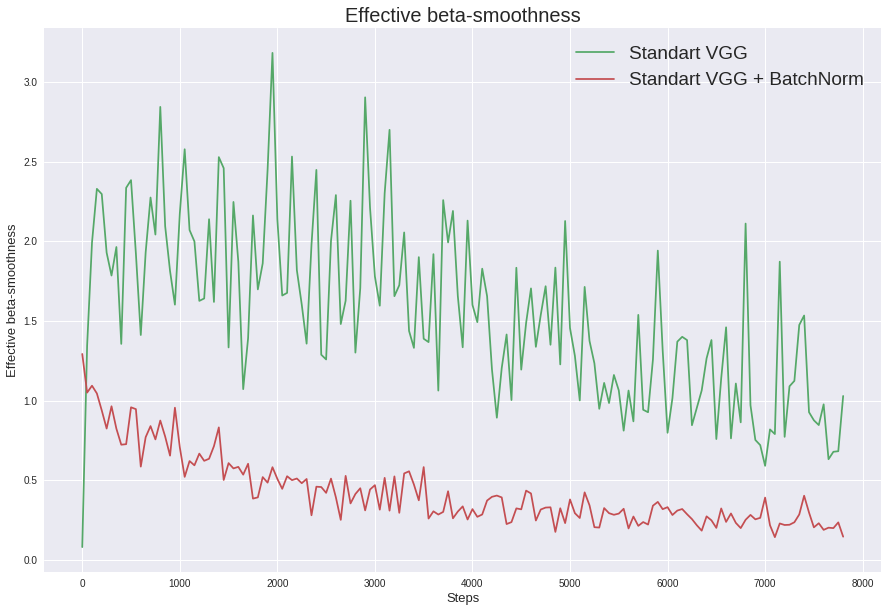

In [ ]:
step = 50
steps = np.arange(0, len(min_curve), step)
plt.figure(figsize=(15, 10))

plt.plot(steps, max_curve[::step], color='C1', label='Standart VGG')

plt.plot(steps, max_batch_curve[::step], color='C2', label='Standart VGG + BatchNorm')

plt.legend(fontsize=19)
plt.title('Effective beta-smoothness', fontsize=20)
plt.ylabel('Effective beta-smoothness', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig(os.path.join(figures_path, 'effective_beta_smoothness.png'), dpi=500, quality=100)
plt.show()